# Py: Productionising predictive models as API
----
*By Jacky Poon*

Once a model is complete, there may be a need to deliver ongoing predictions in some way. The quintessential example for actuaries in insurance would be a pricing model, where, by some mechanism, the modelled prices need to be calculated and displayed to potential customers. However, applications extend beyond this - for example scoring models for triaging requests, identifying fraud, marketing and operational decisions. 

No matter the application, it is very useful when designing predictive models to have:

 1. A graphical interface for making predictions for data scientists and stakeholders to review and
 2. Something that serves an API that IT-managed systems can link to obtain the predictions - e.g. to then display the calculated prices to customer.

Thanks to a tip from a friend, we explore [**Gradio**](https://gradio.app). Gradio is used by the likes of Google, Amazon and Facebook, and appears to meet both of those above use cases in a very easy to use Python package. 

In [1]:
import gradio as gr
from datetime import datetime as dt

First we need a model to productionise. For the example, we have the ``price`` function below. It is intended to be a simplified but algorithmic travel insurance pricing model, with all factor values being fictional. To show how ``gradio`` handles both multiple inputs and multiple outputs, the function returns the price before taxes, and a separate tax amount. In practice a pricing model may have many financial output values.

Since any python can be used, it is possible to reference any python packages or functions, score from a saved GBM, GLM or NN model and perform any calculations. Lightgbm, sci-kit learn all have means to save and load models. 

In [2]:
def price(destination, age1, age2, start_date, end_date, ski_cover):
    """
    Return the price of travel insurance
    """
    base_price_per_day = 7
    dest_factor = lambda d: 2.0 if d == "USA" else 1.0  # e.g. USA medical costs drive higher prices
    age_factor = lambda a: 2.5 if a > 70 else 1.0  # e.g. older ages more vulnerable to health events
    ski_factor = lambda s: 1.7 if s else 1.0  # e.g. skiing is a risky holiday activity
    trip_duration = (dt.strptime(end_date, "%Y-%m-%d") - dt.strptime(start_date, "%Y-%m-%d")).days + 1
    assert trip_duration > 0

    price_before_tax = (
        base_price_per_day * 
        trip_duration * 
        dest_factor(destination) * 
        (
            age_factor(age1) + 
            # Age2 = -1 for no second traveller
            (age_factor(age2) if age2 > 0 else 0)        
        ) * 
        ski_factor(ski_cover)
    )
    price_before_tax_rounded = round(price_before_tax, 2)
    taxes = round(price_before_tax_rounded * 0.12, 2)  # Fictional tax rate, users encouraged to seek own tax advice
    return price_before_tax, taxes

The gradio interface starts a server (on the laptop or machine running this Python code) that provides both the GUI and API functionality.

The ``Interface`` takes in some definitions of the UI, which implies the types of inputs that are needed. 

This will print a message of ``To create a public link, set `share=True` in `launch()`.`` and the graphical interface to input and score the model will be displayed below. Initially this is only accessible to the users of the local machine at this stage for the data scientist to prototype and refine confidentially. 

When the data scientist is ready to make this internally or publically accessible, expectation would be to work with the tech team on the best way to host this securely and then `share=True` can be set. 

In [3]:
gradio_interface = gr.Interface(
    fn = price,
    inputs = [
        # Destination: category - dropdown input
        gr.Dropdown(["USA", "Rest of World"], value="USA"),  
        # Ages: number - slider input
        gr.Slider(0, 130, value=30),
        gr.Slider(-1, 130),
        # Travel dates - Gradio does not have a native date object at time of writing
        # So string input is used
        gr.Textbox("2023-07-01"),
        gr.Textbox("2023-12-01"),
        # Ski cover: boolean true/false - use a checkbox
        gr.Checkbox()
    ],
    outputs = [
        gr.Number(label="Price"),
        gr.Number(label="Tax")
    ]
)
gradio_interface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Screenshots of the output:
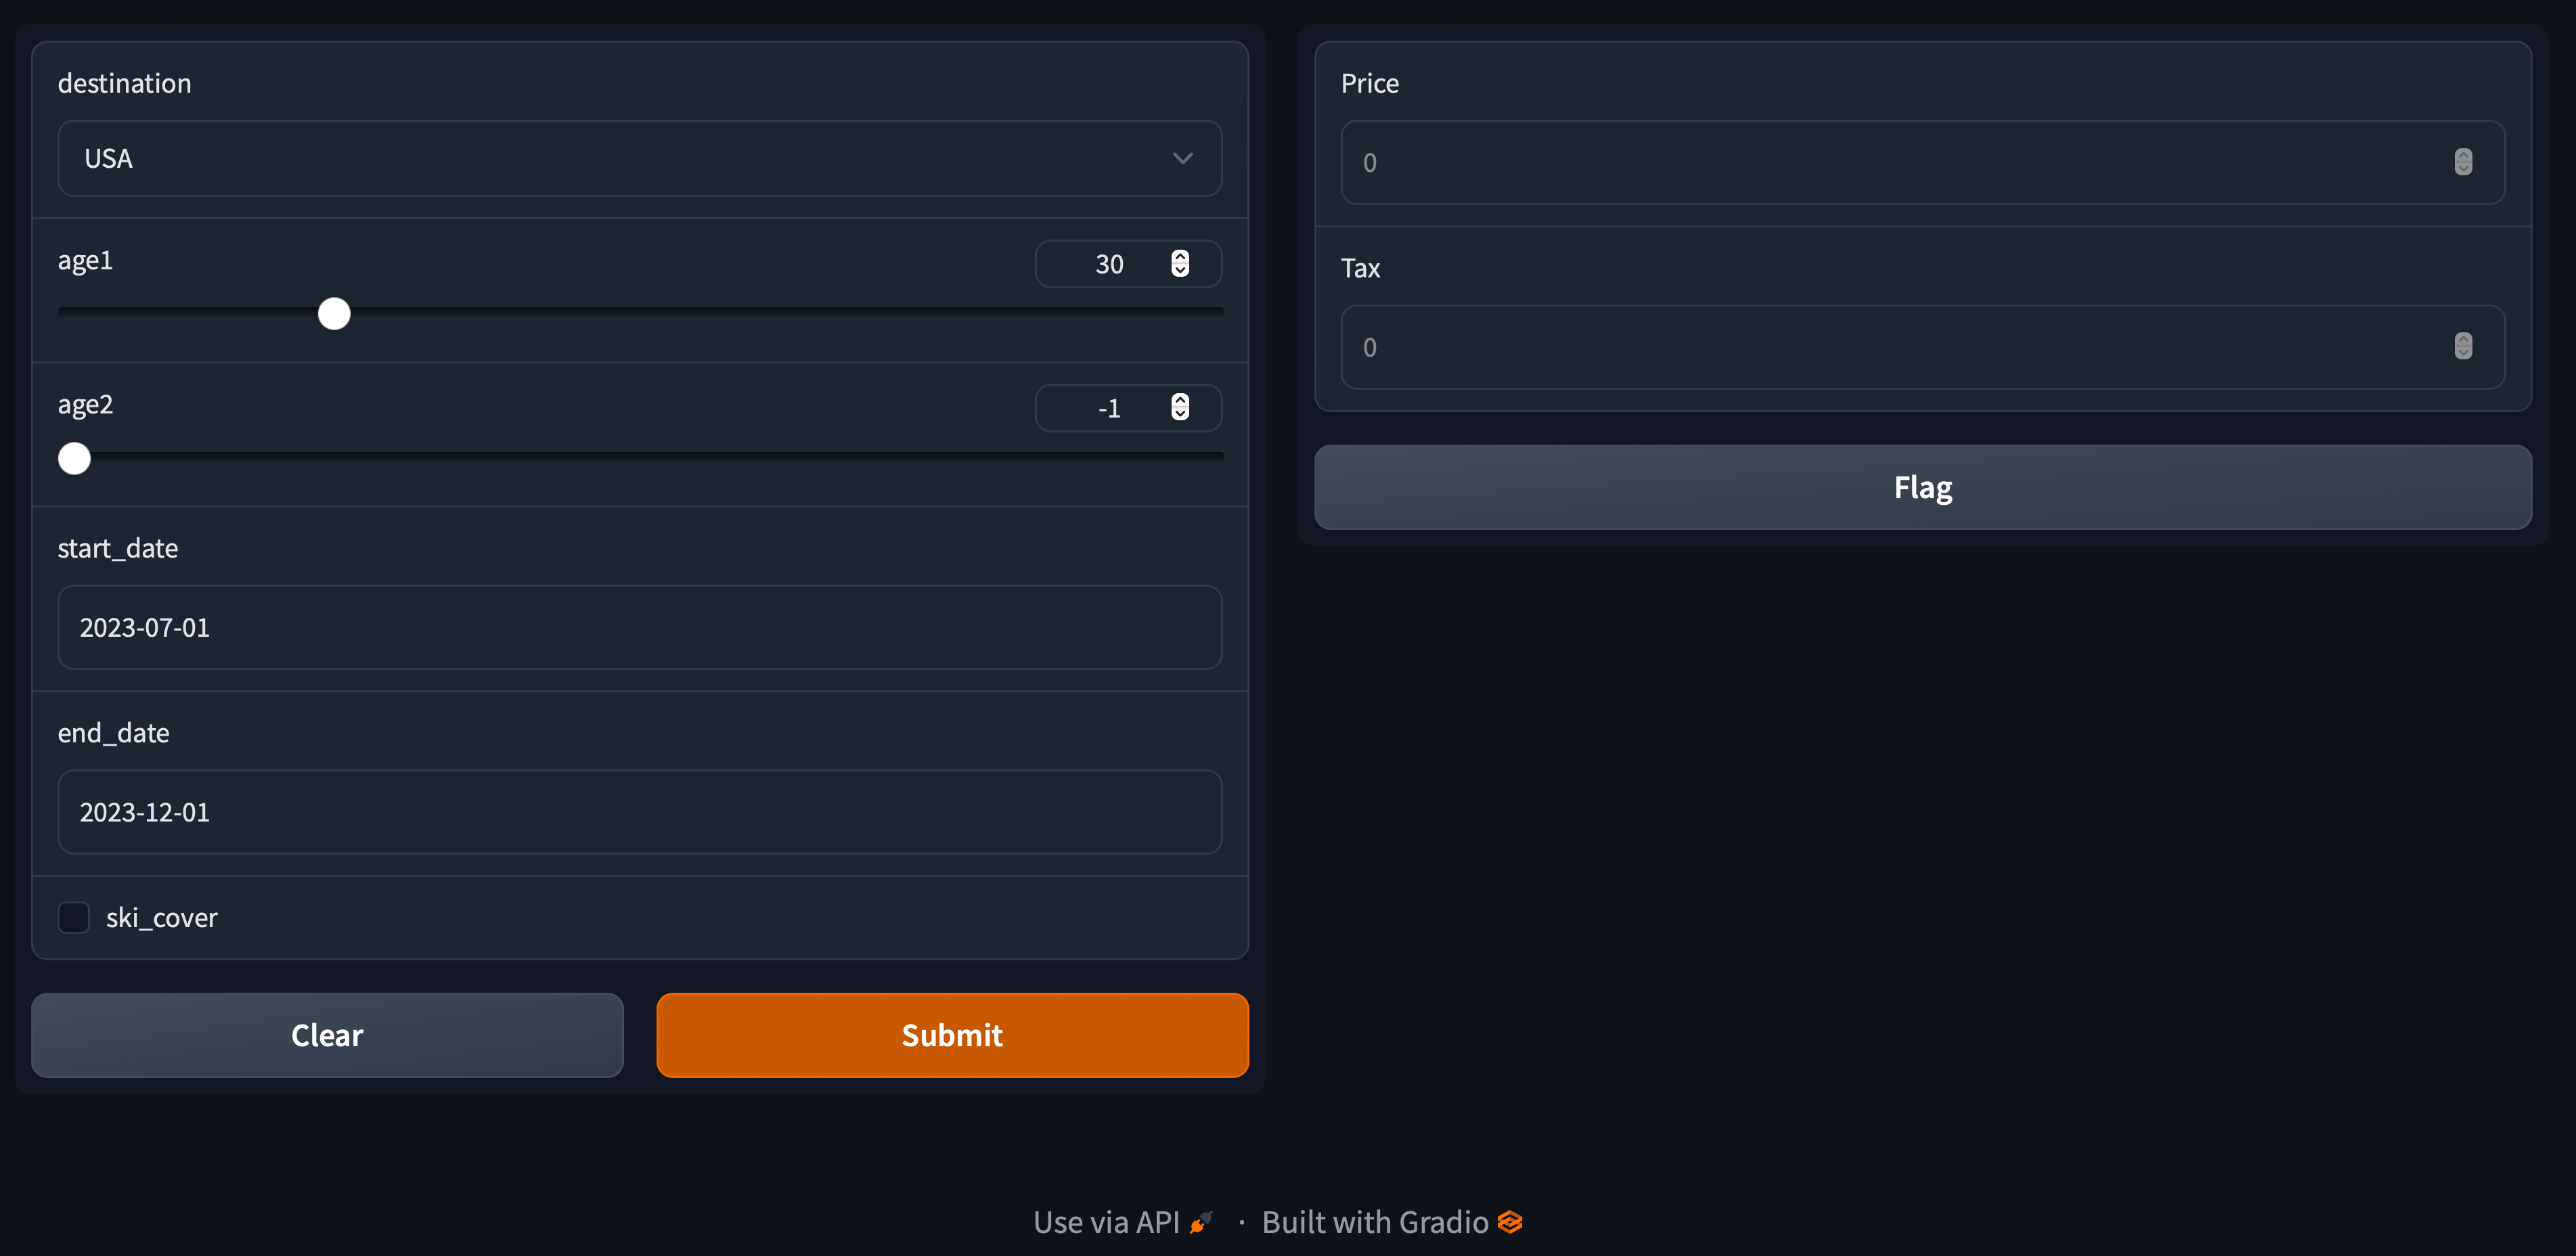

At the bottom of the panel (scroll down if needed), when the gradio server is running, click on "Use via API" to get details of the API as well as sample Python code for querying it. As a data scientist, one can provide this API specification to the tech team so that other systems interfacing with this prediction server can submit data and receive predictions in a pre-agreed format. 

This will provide something like the below:

t the bottom of the panel (scroll down if needed), when the gradio server is running, click on "Use via API" to get details of the API as well as sample Python code for querying it. As a data scientist, one can provide this API specification to the tech team so that other systems interfacing with this prediction server can submit data and receive predictions in a pre-agreed format. 

This will provide something like the below:

In [4]:
import requests

response = requests.post("http://127.0.0.1:7860/run/predict", json={
  "data": [
    "USA",
    30,
    19,
    "2023-07-01",
    "2023-12-01",
    False,
]}).json()

response["data"]

[4312.0, 517.44]

Running it returns a list with the price, and the tax amount.

So the idea for production use would be this Python code could run on a server or in a docker container on the cloud, and the other systems would use the API to query it and get the required predictions (in this case, prices and financials). And during development, gradio can also be used by the data scientist and stakeholders to test and review individual predictions. 

This is a short article as the **gradio** package just appears to be very user friendly to use. 

For further development on this idea, some tips on best practices to that would work with this approach:
 * Important model code can be [version controlled](https://actuariesinstitute.github.io/cookbook/docs/version_control.html) to reduce risk of errors.
 * Data and models can be [version controlled too.](https://dvc.org/doc/use-cases/versioning-data-and-models)
 * Continuous Integration tools can perform automated testing of the API whenever there is a change, and automate deployment of updated models. 
 * Performance is relevant to scalability to a high number of predictions per second. Upgrading to latest Python version may also help with performance, 3.11 claims [10-60% performance improvement](https://docs.python.org/3/whatsnew/3.11.html)
 * [Numba](https://numba.pydata.org) can also provide just-in-time compilation to speed up Python calculations (like those used for the financial calculations above) at scale. 
 * [Caching results from recent queries](https://docs.python.org/3/library/functools.html#functools.lru_cache) may also be helpful to performance if the calculations are time consuming, but duplicate queries are expected. 